In [1]:
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import classification_report, roc_curve
from xgboost import XGBClassifier

/Users/pablomirallesgonzalez/.micromamba/envs/maadm-spd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# for reproducibility
SEED = 42
np.random.seed(SEED)
optuna_sampler = optuna.samplers.TPESampler(seed=SEED)

## Read data

In [3]:
def build_df(neg_file, pos_file):
    # read csv
    neg_df = pd.read_csv(neg_file)
    pos_df = pd.read_csv(pos_file)

    pos_df["label"] = 1
    neg_df["label"] = 0

    df = pd.concat([pos_df, neg_df])

    # drop columns with a single value
    unique_columns = df.columns[df.nunique() == 1]
    df.drop(unique_columns, axis=1, inplace=True)

    # drop unique columns and version columns (they will vary over time)
    df.drop(["hash", "PackageName", "min_andrversion", "max_andrversion", "target_andrversion"], axis=1, inplace=True)

    return df

We drop columns that have unique values in each row, as well as columns with a single value, since they are not discriminative. We also drop columns related to versions, since they won't extrapolate across time.

In [4]:
df = build_df("2000_goodware_2018_2020_features.csv", "2000_malware_2018_2020_features.csv")

Let's split the data in train and test:

In [5]:
X = df.drop("label", axis=1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## Tuning hyperparameters

We will use ROC AUC as metric, to improve the overall scores accross thresholds. We want to select the threshold afterwards, trying to prioritize false negatives over false positives if possible.

In [6]:
def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),
    }

    # Create the XGBoost classifier with the hyperparameters
    classifier = XGBClassifier(**params)

    # Perform cross-validation
    scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring="roc_auc")

    # Return the mean accuracy score as the objective value
    return scores.mean()

# Create an Optuna study
study = optuna.create_study(direction='maximize', sampler=optuna_sampler)

# Optimize the objective function
study.optimize(objective, n_trials=25)

# Get the best hyperparameters and objective value
best_params = study.best_params
best_score = study.best_value

# Print the best hyperparameters and objective value
print("Best Hyperparameters:", best_params)
print("Best Objective Value:", best_score)


[I 2024-04-07 18:46:41,996] A new study created in memory with name: no-name-e2ec0573-4caf-46d0-9aad-866e5311dc8b
[I 2024-04-07 18:46:45,653] Trial 0 finished with value: 0.9973348479052417 and parameters: {'n_estimators': 137, 'max_depth': 15, 'learning_rate': 0.09454306819536169, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.15599452033620265, 'reg_alpha': 0.5808361216819946, 'reg_lambda': 8.661761457749352, 'scale_pos_weight': 30.45463557541723}. Best is trial 0 with value: 0.9973348479052417.
[I 2024-04-07 18:46:48,391] Trial 1 finished with value: 0.9967978077246356 and parameters: {'n_estimators': 171, 'max_depth': 3, 'learning_rate': 0.41472250004816347, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'gamma': 0.18182496720710062, 'reg_alpha': 1.8340450985343382, 'reg_lambda': 3.0424224295953772, 'scale_pos_weight': 26.713065149979656}. Best is trial 0 with value: 0.9973348479052417.
[I 2024-04-07 18:46:51,089] Trial

Best Hyperparameters: {'n_estimators': 184, 'max_depth': 10, 'learning_rate': 0.0407430238913532, 'subsample': 0.7454627538346726, 'colsample_bytree': 0.7086458938062694, 'gamma': 0.009855204243991708, 'reg_alpha': 0.10001712666562684, 'reg_lambda': 1.7681818169750754, 'scale_pos_weight': 24.46735861827253}
Best Objective Value: 0.9976110854619706


Let's select the threshold as well.

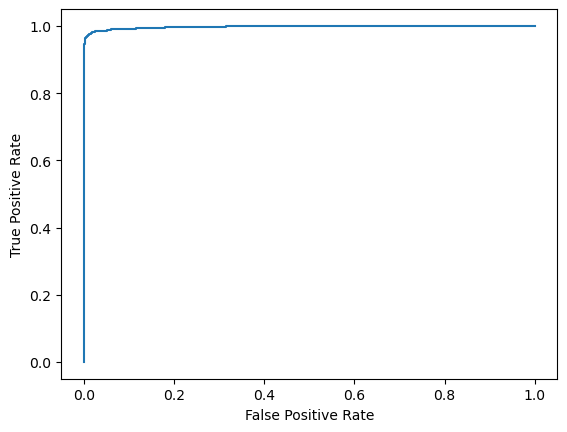

In [7]:
# KFold 5 split and iterate over the splits
kf = KFold(n_splits=5)

y_preds = []

for train_index, test_index in kf.split(X_train):
    clf = XGBClassifier(**best_params)
    clf.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    y_pred = clf.predict_proba(X_train.iloc[test_index])[:, 1]
    y_preds.append(y_pred)

y_preds = np.concatenate(y_preds)

fpr, tpr, thresholds = roc_curve(y_train, y_preds)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.show()

We see that there is not a lot to be gained from compromising the false positive rate. Let's assume for example that are not willing to go below 3% of false positives. What is the best TPR we can get?

In [8]:
tpr[fpr <= 0.03].max()

0.9849498327759197

In [9]:
# select corresponding threshold
optimal_threshold = thresholds[fpr <= 0.03].min()
optimal_threshold

0.4850821

## Evaluating the model

In [10]:
clf = XGBClassifier(**best_params)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7086458938062694, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.009855204243991708,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0407430238913532,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=184, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [11]:
y_pred = clf.predict_proba(X_test)[:, 1] > optimal_threshold
print(classification_report(y_test, y_pred, target_names=["goodware", "malware"], digits=4))

              precision    recall  f1-score   support

    goodware     0.9692    0.9742    0.9717       194
     malware     0.9756    0.9709    0.9732       206

    accuracy                         0.9725       400
   macro avg     0.9724    0.9726    0.9725       400
weighted avg     0.9725    0.9725    0.9725       400



In [12]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix / confusion_matrix.sum().sum() * 100

Predicted,False,True
Actual,,
0,47.25,1.25
1,1.50,50.00


## Feature analysis

In this section we analyze the most important features for our model, as well as their distribution across the two classes.

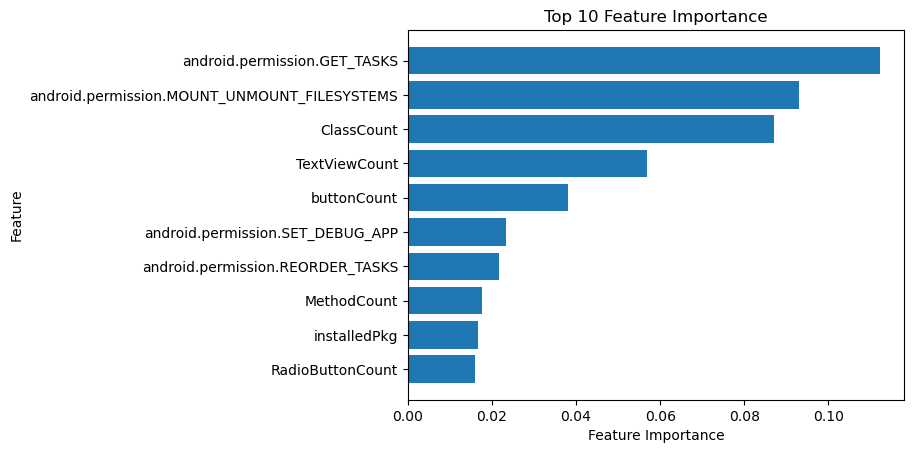

In [13]:
# Get the feature importance from the trained classifier
feature_importance = clf.feature_importances_

# Get the indices of the top 10 features
top_10_indices = feature_importance.argsort()[-10:]

# Get the names of the top 10 features
top_10_features = X.columns[top_10_indices]

# Get the importance values of the top 10 features
top_10_importance = feature_importance[top_10_indices]

# Create a bar plot of the top 10 features and their importance values
plt.barh(top_10_features, top_10_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.show()


In [14]:
# Get the positive and negative examples
positive_examples = df[df['label'] == 1]
negative_examples = df[df['label'] == 0]

# Get the values of the most important features
most_important_features = top_10_features.tolist()
binary_features = [feature for feature in most_important_features if len(df[feature].unique()) == 2]
numeric_features = [feature for feature in most_important_features if feature not in binary_features]

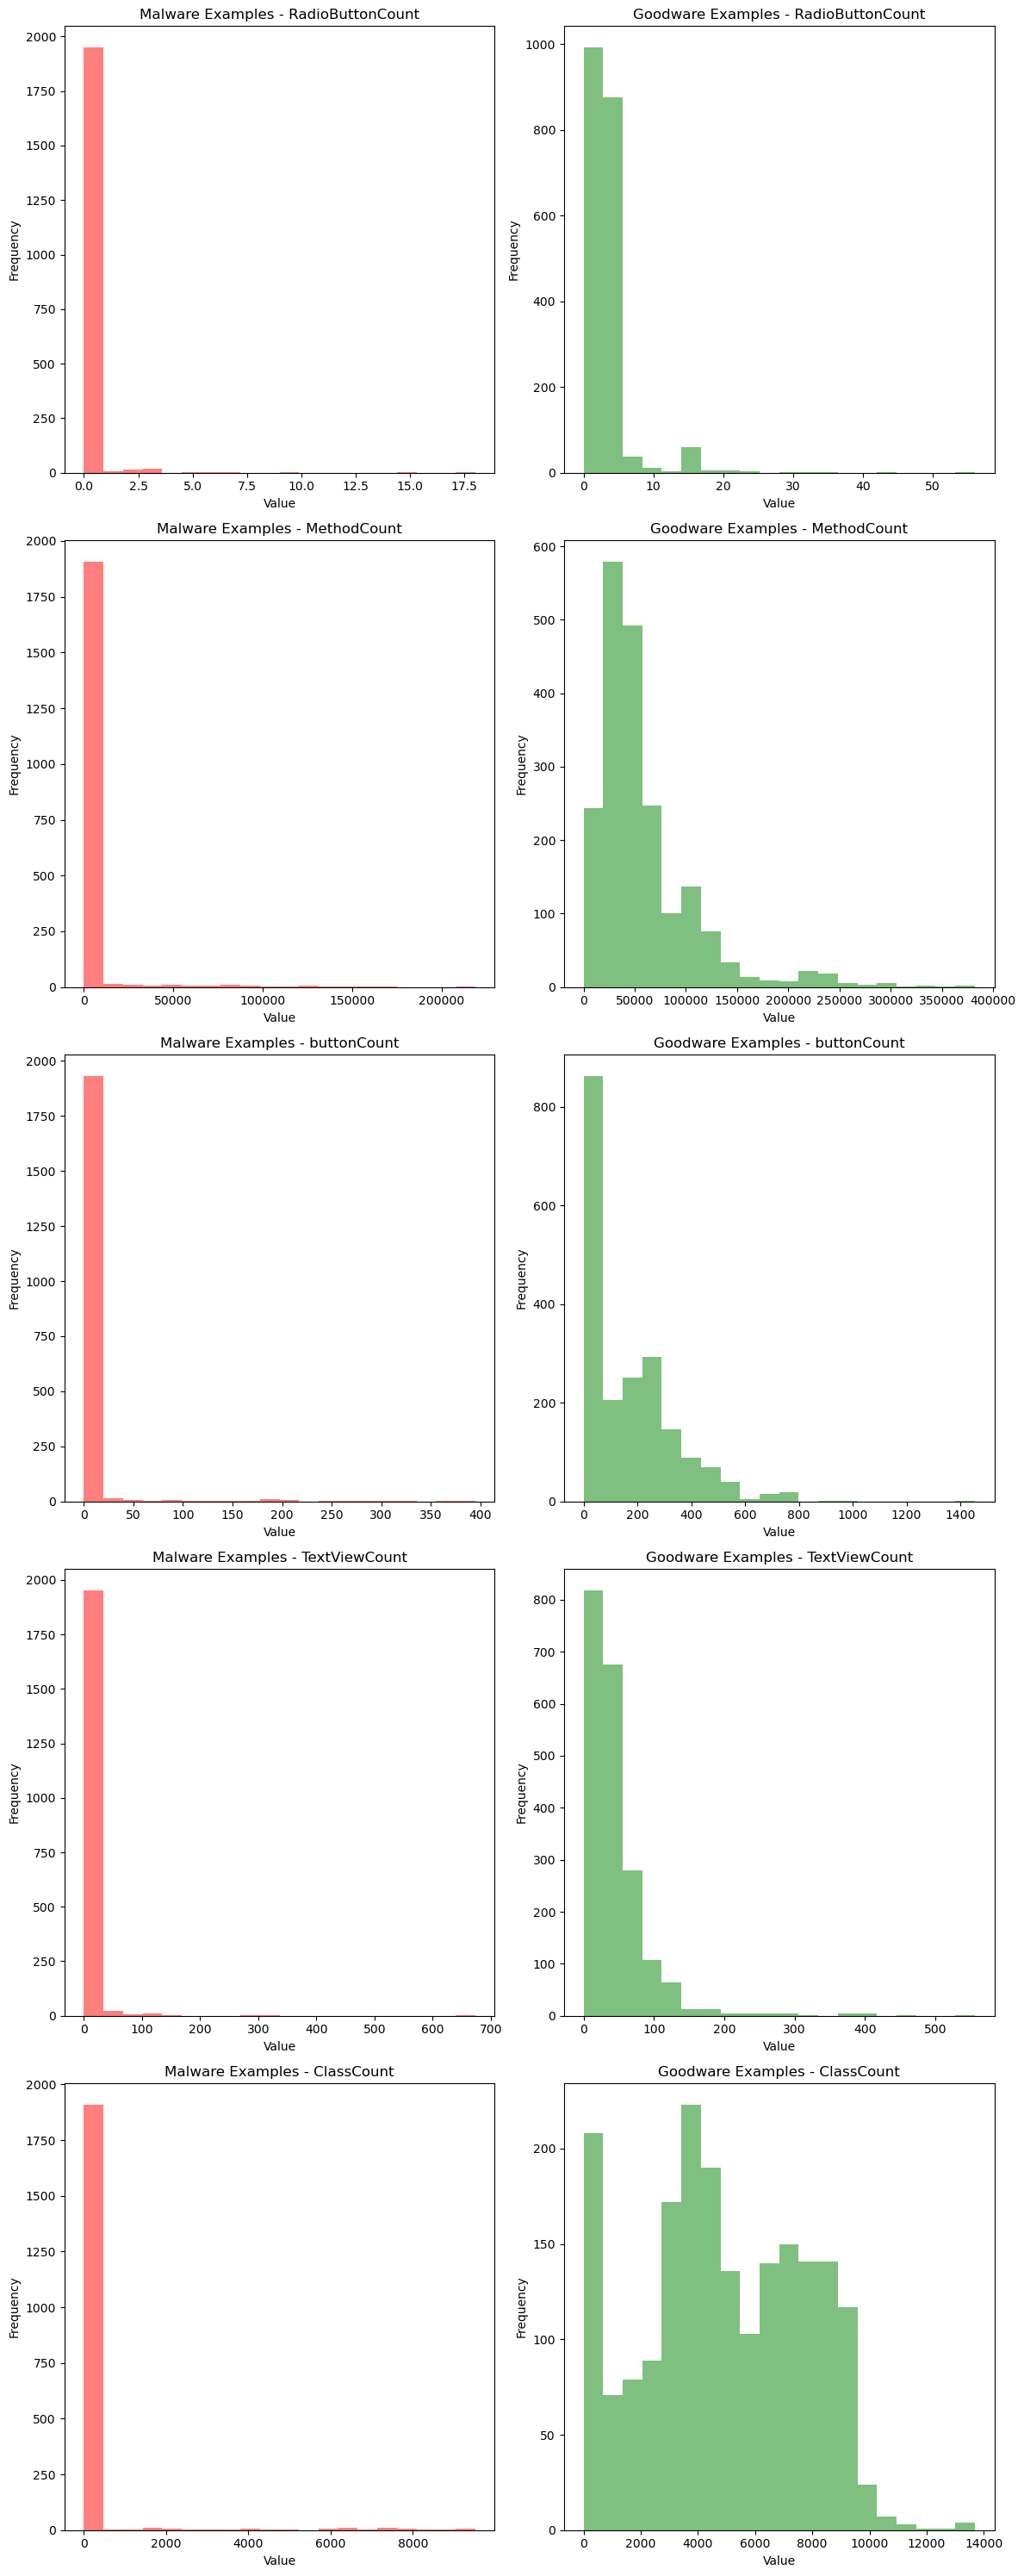

In [15]:
# Plot the distribution of the variables for both positive and negative examples
fig, axes = plt.subplots(nrows=len(numeric_features), ncols=2, figsize=(12, 6 * len(numeric_features)))

for i, feature in enumerate(numeric_features):
    # Plot the distribution for positive examples
    axes[i, 0].hist(positive_examples[feature], bins=20, color='red', alpha=0.5)
    axes[i, 0].set_title(f'Malware Examples - {feature}')
    axes[i, 0].set_xlabel('Value')
    axes[i, 0].set_ylabel('Frequency')

    # Plot the distribution for negative examples
    axes[i, 1].hist(negative_examples[feature], bins=20, color='green', alpha=0.5)
    axes[i, 1].set_title(f'Goodware Examples - {feature}')
    axes[i, 1].set_xlabel('Value')
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

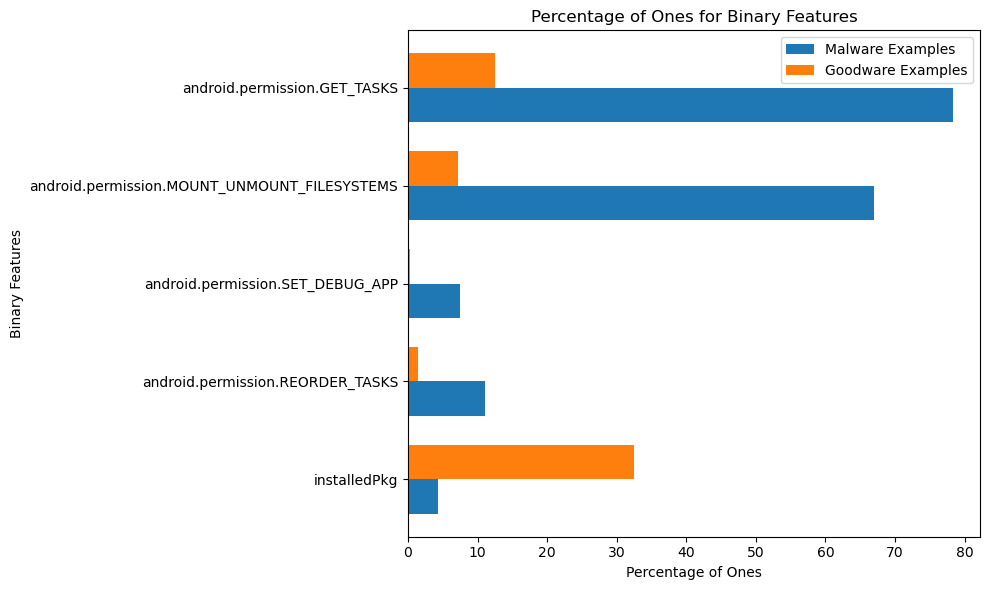

In [16]:
# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
y = range(len(binary_features))
height = 0.35

# Calculate the percentage of ones for each binary feature in positive examples
positive_percentages = []
for feature in binary_features:
    positive_percentages.append(positive_examples[feature].mean() * 100)

# Calculate the percentage of ones for each binary feature in negative examples
negative_percentages = []
for feature in binary_features:
    negative_percentages.append(negative_examples[feature].mean() * 100)

# Plot the bar plots side by side
ax.barh(y, positive_percentages, height, label='Malware Examples')
ax.barh([i + height for i in y], negative_percentages, height, label='Goodware Examples')

# Set the labels, title, and ticks
ax.set_ylabel('Binary Features')
ax.set_xlabel('Percentage of Ones')
ax.set_title('Percentage of Ones for Binary Features')
ax.set_yticks([i + height/2 for i in y])
ax.set_yticklabels(binary_features)
ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


## Attacking the model

### Manual attack

A big difference between the two classes can be seen in the distribution graphs of the numeric variables:

The malign examples, for the most part, have a very low number in the ```('TextViewCount', 'buttonCount', 'MethodCount', 'ClassCount')``` fields, while the benign examples have a higher number in these attributes. These features are very easy to manipulate in programs, so if we manage to hack the model using these we could apply it in a real world setting.

Therefore, we have decided to alter these variables in a benign example so that the model will return a false negative. In particular, we have focused on the ```MethodCount``` and ```ClassCount``` attributes, since they are apparently the simplest to alter in a real case by adding redundant functions or classes.

In [17]:
selected_sample = positive_examples.iloc[1].drop("label").to_frame().T
orig_preds = clf.predict(selected_sample)
selected_sample.loc[:, "ClassCount"] = 40000
selected_sample.loc[:, "MethodCount"] = 40000
attacked_preds = clf.predict(selected_sample)
print(f"Original Prediction: {orig_preds[0]}")
print(f"Attacked Prediction: {attacked_preds[0]}")
print(f"Original Label: {1}")

Original Prediction: 1
Attacked Prediction: 0
Original Label: 1


### Using SecML

Creation of ```CClassifier```, compatible with ```CAttackEvasionPGDLS```, class in charge of performing the attack to the new model automatically.

In [18]:
from secml.data import CDataset
from secml.ml.classifiers import CClassifierLogistic
from secml.ml.peval.metrics import CMetricAccuracy
from secml.adv.attacks.evasion import CAttackEvasionPGDLS
from secml.array import CArray

In [19]:
metric = CMetricAccuracy()

# Convertir los datos a los formatos requeridos por secml
train_dataset = CDataset(X_train, y_train)
test_dataset = CDataset(X_test, y_test)

# Crear un objeto de clasificador, en este caso, usaremos SVM con un kernel RBF
sec_clf = CClassifierLogistic()

# Entrenar el clasificador
sec_clf.fit(train_dataset.X, train_dataset.Y)

y_pred = sec_clf.predict(test_dataset.X)
acc = metric.performance_score(y_true=test_dataset.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Accuracy on test set: 92.00%


In [20]:
# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 1e-2,
    'max_iter': 200,
    'eps': 1e-4,
}

noise_type = 'l1'  # Type of perturbation 'l1' or 'l2'
dmax = 100  # Maximum perturbation
lb = 0
ub = CArray([1 if "permission" in col else 1e8 for col in X_train.columns])
y_target = 0  # None if `error-generic` or a class label for `error-specific`

pgd_ls_attack = CAttackEvasionPGDLS(
    classifier=sec_clf,
    double_init=False,
    distance=noise_type,
    dmax=dmax,
    lb=lb, ub=ub,
    solver_params=solver_params,
    y_target=y_target)

# Run the evasion attack on x0
x0 = positive_examples.sample(1).drop("label", axis=1).values
y0 = 1  # real label
y_pred_after_attack, _, manipulated_x0, _ = pgd_ls_attack.run(x0, y0)

print("Original x0 label: ", y0)
print("Adversarial example label (PGD-LS): ", y_pred_after_attack.item())

Original x0 label:  1
Adversarial example label (PGD-LS):  0


In [21]:
for col, val_new, val_prev in zip(X.columns, manipulated_x0.X, x0[0]):
    if val_new != val_prev:
        print(f"{col}: from {val_prev} to {val_new}")

DefaultPermissionCount: from 6 to 0
providerCount: from 1 to 0
CryptoCount: from 0 to 93


## Evaluate the model on the extra dataset

In [22]:
############################################################################################
# Insert your dataset in the following parameters
############################################################################################
extra_df = build_df("2000_goodware_2018_2020_features.csv", "2000_malware_2018_2020_features.csv")
X_extra = df.drop("label", axis=1)
y_extra = df["label"]

y_pred = clf.predict_proba(X_extra)[:, 1] > optimal_threshold
print(classification_report(y_extra, y_pred, target_names=["goodware", "malware"], digits=4))

              precision    recall  f1-score   support

    goodware     0.9970    0.9950    0.9960      2000
     malware     0.9950    0.9970    0.9960      2000

    accuracy                         0.9960      4000
   macro avg     0.9960    0.9960    0.9960      4000
weighted avg     0.9960    0.9960    0.9960      4000

